Import and Configurations

In [1]:
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Sat Nov 23 02:42:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P5              10W /  55W |    601MiB /  8188MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Other imports and helper functions
import mujoco
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=21, suppress=True, linewidth=100)

from IPython.display import clear_output
# clear_output()

import util
import controller

Import model

In [3]:
model = mujoco.MjModel.from_xml_path('cartpole.xml')
data = mujoco.MjData(model)
height=400
width=600
renderer = mujoco.Renderer(model,height,width)
dt = model.opt.timestep

print("mass of cart is:")
print(model.body_mass[model.geom_bodyid[model.geom('cart').id]])
print("mass of the pole is:")
print(model.body_mass[model.geom_bodyid[model.geom('cpole').id]])
# --------------------------------------------------------------------
mujoco.mj_kinematics(model, data)

mass of cart is:
8.000000000000002
mass of the pole is:
4.1987385815227585


render image

""

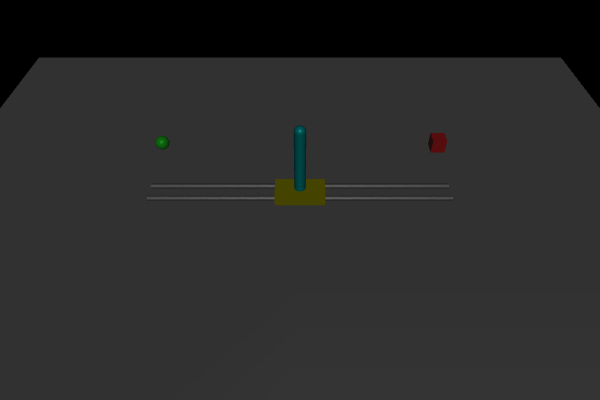

In [5]:
util.renderImage(model,data,renderer,True,False) # change to False to turn off joint visibility; change to True to be transparent
scene_option = util.renderVideoOpt(model,True,False)

render video

In [6]:
# Physics options
model.opt.gravity = (0, 0, -9.8)

# Buffers
frames = []
times = []

ctrl = []
err = []
sensordata = []

mujoco.mj_resetData(model, data)
data.ctrl = 0 

# Constants
# target = 0?
duration = 5   # (seconds)
framerate = 60  # (Hz)

while data.time < duration:
    # step
    mujoco.mj_step(model, data)
    times.append(data.time)
    sensordata.append(data.sensordata.copy())
    
    # ctrl
    # data.ctrl = controller.nonlinear(controller.myController)
    data.ctrl = -10
    ctrl.append(data.ctrl)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)
        
sensordata = np.array(sensordata)
media.show_video(frames, fps=framerate)

sensordata
start is: [0.  0.  9.8 0. ]
end is: [-0.05042228038137227  0.                   9.8                  0.                 ] 

ctrl
start is: [-10.]
end is: [-10.] 



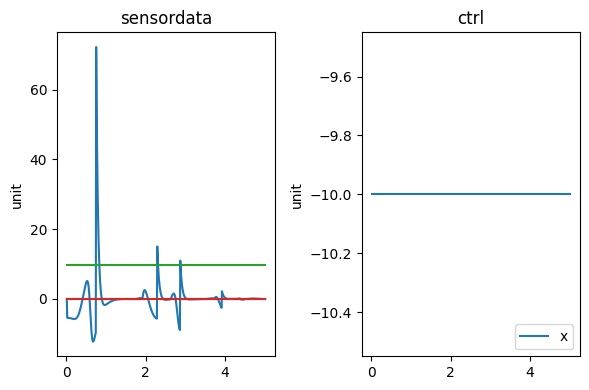

In [7]:
util.plotter(times,{'sensordata':sensordata,'ctrl':ctrl},['x','y','z'])

In [8]:
name = 'testVid.mp4'
util.saveVideo(name,height,width,frames,framerate,False)

/home/navi/Mujoco/ECE598
